In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import project_env as pe
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import error_analysis as ea
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [2]:
train = pd.read_csv('data_processing/output/train.csv')
val = pd.read_csv('data_processing/output/val.csv')
test = pd.read_csv('data_processing/output/test.csv')

# Target Variable

In [3]:
#target variable of rearrest in 5 years
X_train, y_train = pe.create_target(train, years = 5)
X_val, y_val = pe.create_target(val, years = 5)

X_test, y_test = pe.create_target(test, years = 5)

In [4]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 51.9046644379 percent were rearrested.
Test: 51.8282699654 percent were rearrested.


In [5]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

In [6]:
#remove non-feature columns
X_test=X_test.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_test=X_test.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

### Default Parameters

In [7]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train,y_train)

gbt_pred_train = gbt.predict(X_train)
gbt_pred_val = gbt.predict(X_val)

In [8]:
# gbt accuracy
gbt_accu_train = sklearn.metrics.accuracy_score(y_train,gbt_pred_train)
gbt_accu_test = sklearn.metrics.accuracy_score(y_val,gbt_pred_val)

print("Accuracy on Training Dataset: {}".format(gbt_accu_train))
print("Accuracy on Val Dataset: {}".format(gbt_accu_test))

Accuracy on Training Dataset: 0.7519274066998703
Accuracy on Val Dataset: 0.7509550663998544


In [9]:
gbt_precision = sklearn.metrics.precision_score(y_val,gbt_pred_val)
gbt_recall = sklearn.metrics.recall_score(y_val,gbt_pred_val)
gbt_f_score = sklearn.metrics.f1_score(y_val,gbt_pred_val)

print("Precision: {}".format(gbt_precision))
print("Recall: {}".format(gbt_recall))
print("F-Score: {}".format(gbt_f_score))

Precision: 0.7543829494671709
Recall: 0.7702702702702703
F-Score: 0.7622438346648142


In [10]:
#confusion matrix for val set
gbt_cm = sklearn.metrics.confusion_matrix(y_val,gbt_pred_val)
gbt_cm    #add cm.to_latex?

array([[3867, 1429],
       [1309, 4389]])

### Parameter Optimization

In [354]:
n_estimators = [100, 300, 500]
learning_rates = [0.05, 0.1, 0.5]
max_depths = [3,5,10]
min_samples_splits = [2,4,8]

In [355]:
model_specs = pd.DataFrame(list(product(n_estimators, learning_rates, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split'])

model_specs['ModelID'] = range(1, len(model_specs)+1)

model_specs['ModelID'] = 'Model' + model_specs['ModelID'].astype(str)

model_specs.head()

,n_estimator,learning_rate,max_depth,min_samples_split,ModelID
0,100,0.05,3,2,Model1
1,100,0.05,3,4,Model2
2,100,0.05,3,8,Model3
3,100,0.05,5,2,Model4
4,100,0.05,5,4,Model5


In [356]:
models = {}

for i in range(len(model_specs)):
    models[model_specs.iloc[i,:]['ModelID']] = \
    GradientBoostingClassifier(n_estimators = int(model_specs.iloc[i,:]['n_estimator']),\
                               learning_rate = float(model_specs.iloc[i,:]['learning_rate']),\
                               max_depth = int(model_specs.iloc[i,:]['max_depth']),\
                               min_samples_split = int(model_specs.iloc[i,:]['min_samples_split'])
                              )

In [27]:
best_model = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 5, min_samples_split = )

In [28]:
best_model.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=4, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [357]:
models_fit = {k: v.fit(X_train,y_train) for k, v in models.items()}

In [358]:
models_predict_val = {k: v.predict(X_val) for k, v in models_fit.items()}

In [359]:
models_predict_prob = {k: v.predict_proba(X_val) for k, v in models_fit.items()}

In [360]:
model_specs.index = model_specs['ModelID']

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val[model_num])

In [361]:
#best model
model_specs.loc[model_specs['F-Score'].idxmax(axis=1),]

n_estimator               300
learning_rate             0.1
max_depth                   5
min_samples_split           4
ModelID               Model41
Val Accuracy         0.759232
Precision            0.761888
Recall                0.77887
F-Score              0.770286
Name: Model41, dtype: object

In [362]:
model_specs.to_csv('results/gbt_optimization_results.csv')

#### Best Model's Predictions and Feature Importance

In [46]:
best_model_predicted_prob = best_model.predict_proba(X_val)
best_model_predictions = best_model.predict(X_val)

In [ ]:
feature_imp = pd.DataFrame(list(zip(X_train.columns, best_model.feature_importances_)))
feature_imp.columns = ['Column Name', 'Importance']
print (feature_imp.sort(columns = 'Importance', ascending = False)[0:5].to_latex())

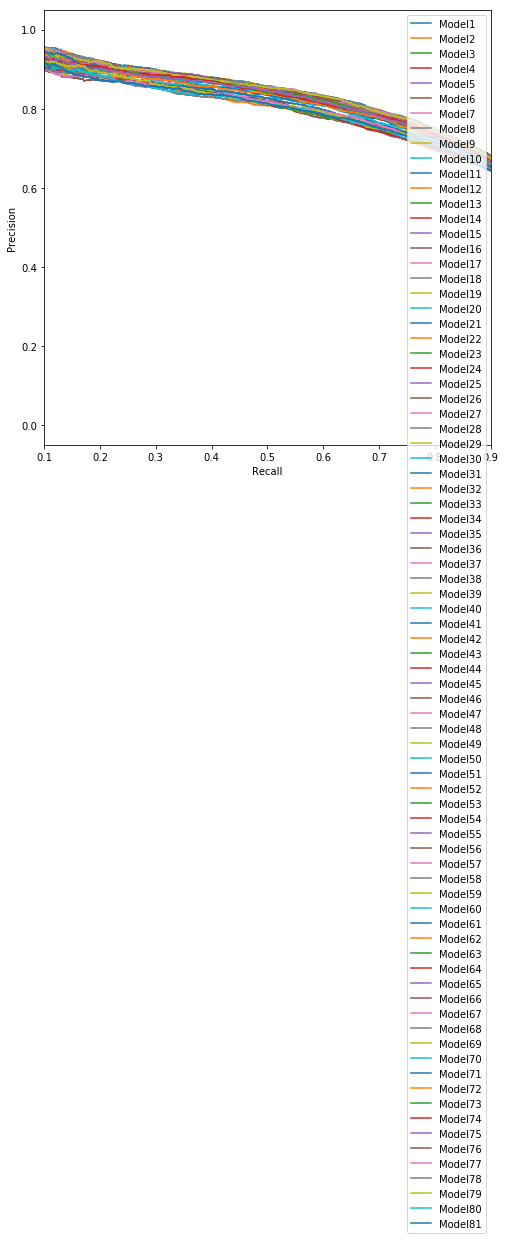

In [365]:
for model_num in list(model_specs['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    line = pylab.plot(recall, precision, label = model_num)
    pylab.legend(loc='upper right')
    pylab.xlim(.1,.9)
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    

plt.gcf().set_size_inches(8,8) 
plt.savefig('precision_recall_param_opt.png')
plt.show()

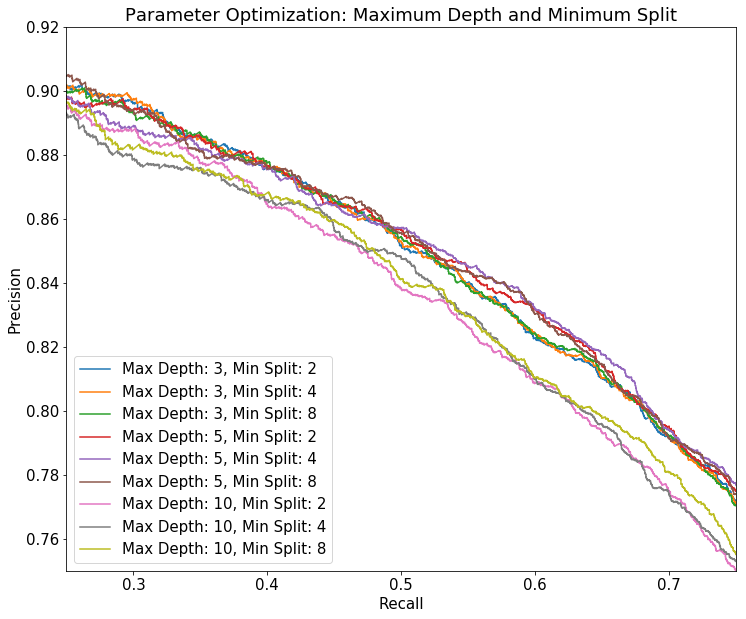

In [659]:
for model_num in list(model_specs[(model_specs['learning_rate']==0.1) & (model_specs['n_estimator']==300)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Max Depth: ' + str(model_specs.loc[model_num, 'max_depth']) + ', Min Split: ' + str(model_specs.loc[model_num, 'min_samples_split'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='lower left', fontsize = 15)
    pylab.xlim(.25,.75)
    pylab.ylim(.75, .92)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    pylab.xlabel('Recall', fontsize = 15)
    pylab.ylabel('Precision', fontsize = 15)
    pylab.title('Parameter Optimization: Maximum Depth and Minimum Split', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(12,10) 
plt.savefig('precision_recall_param_opt_depth_split.png')
plt.show()

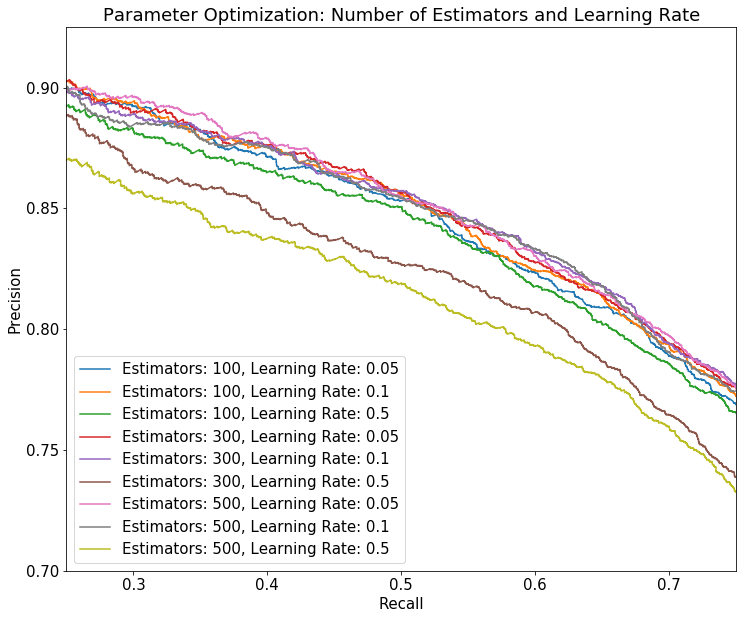

In [660]:
for model_num in list(model_specs[(model_specs['max_depth']==5) & (model_specs['min_samples_split']==4)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Estimators: ' + str(model_specs.loc[model_num, 'n_estimator']) +\
    ', Learning Rate: ' + str(model_specs.loc[model_num, 'learning_rate'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='lower left', fontsize = 15)
    pylab.xlim(.25,.75)
    pylab.ylim(.70, .925)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    pylab.xlabel('Recall', fontsize = 15)
    pylab.ylabel('Precision', fontsize = 15)
    pylab.title('Parameter Optimization: Number of Estimators and Learning Rate', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(12,10) 
plt.savefig('precision_recall_param_opt_est_lr.png')
plt.show()

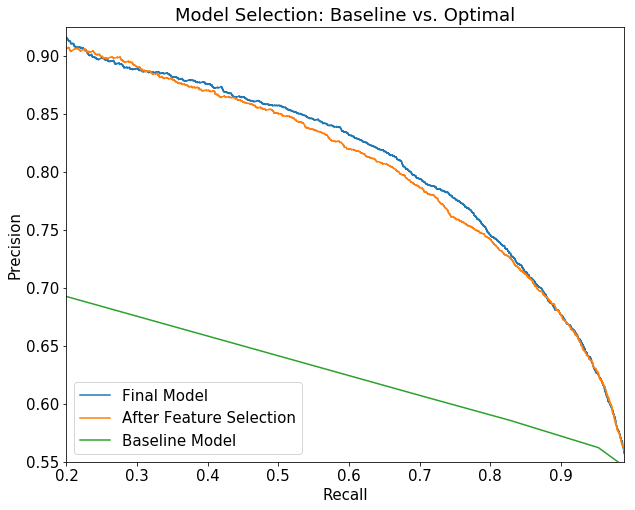

In [661]:
curve = precision_recall_curve(y_val, models_predict_prob['Model41'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'Final Model')

curve = precision_recall_curve(y_val, models_predict_prob['Model10'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'After Feature Selection')

baseline_precision = np.load('precision_baseline.npy')
baseline_recall = np.load('recall_baseline.npy')

line = pylab.plot(baseline_recall, baseline_precision, label = 'Baseline Model')

pylab.legend(loc='lower left', fontsize = 15)
pylab.xlim(.20,.99)
pylab.ylim(.55, .925)
pylab.xlabel('Recall', fontsize = 15)
pylab.ylabel('Precision', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
pylab.title('Model Selection: Baseline vs. Optimal', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(10,8) 
plt.savefig('precision_recall_baseline_v_optimal.png')
plt.show()

### Confusion Matrix and Risk CSV

In [26]:
gbt_cm = sklearn.metrics.confusion_matrix(y_val,models_predict_val['Model41'])
gbt_cm    #add cm.to_latex?
print (pd.DataFrame(gbt_cm).to_latex())

NameError: name 'models_predict_val' is not defined

In [11]:
train = pd.read_csv('data_processing/output/train.csv')
val = pd.read_csv('data_processing/output/val.csv')
test = pd.read_csv('data_processing/output/test.csv')

In [481]:
#target variable of rearrest in 5 years
og_X_train, og_y_train = pe.create_target(train, years = 5)
og_X_val, og_y_val = pe.create_target(val, years = 5)
og_X_test, og_y_test = pe.create_target(test, years = 5)

In [482]:
val_predict_proba = models_fit['Model41'].predict_proba(X_val)

test_predict_proba = models_fit['Model41'].predict_proba(X_test)

train_predict_proba = models_fit['Model41'].predict_proba(X_train)

In [538]:
val_risk = og_X_val[['BOFI_NBR', 'UNIQUE_ID']]
val_risk['Risk'] = val_predict_proba[:,1].copy()

test_risk = og_X_test[['BOFI_NBR', 'UNIQUE_ID']]
test_risk['Risk'] = test_predict_proba[:,1].copy()

train_risk = og_X_train[['BOFI_NBR', 'UNIQUE_ID']]
train_risk['Risk'] = train_predict_proba[:,1].copy()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [543]:
test_risk.to_csv('results/train_risk.csv')
train_risk.to_csv('results/train_risk.csv')
val_risk.to_csv('results/val_risk.csv')

### Error Analysis (Perform on the best model)

In [48]:
#preds_to_analyze = models_predict_val['Model41']

preds_to_analyze = best_model_predictions

np.save('pred_val_5yr_gbt_optimal.npy', preds_to_analyze)

In [141]:
probs_to_analyze = best_model_predicted_prob

In [49]:
val_data = pd.read_csv('data_processing/output/data_val.csv', encoding = "ISO-8859-1", \
                       low_memory=False, index_col=0)

In [50]:
val_data['AGE'] = val_data['AGE']/365

In [500]:
val_data.to_csv('data_processing/output/data_val.csv')

In [160]:
numeric = ['BAR_ADMIT_DAYS','NEXT_ARREST_TIME','CRIMINAL_FLAG','FINAL_DETENTION_FLAG','HABITUAL_OFFENDER_FLAG',\
           'INITIAL_DETENTION_FLAG','JUVENILE_FLAG','TOT_NUM_DEF','MULTIPLE_DEF_FLAG','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE', 'ARREST_TO_SCREEN']

numeric_exc_binary = ['NEXT_ARREST_TIME','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE']

categorical =['CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

categorical_and_binary = ['CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX', 'CRIMINAL_FLAG',\
        'JUVENILE_FLAG', 'MULTIPLE_DEF_FLAG']

In [168]:
val_error = ea.Error_Analysis('5_yr_gbt_optimal', 'data_processing/output/data_val.csv', \
                              'pred_val_5yr_gbt_optimal.npy')

val_error.create_err_analysis_df(5)

val_error.divide_preds()

10994
10994


In [52]:
data = val_error.err_analysis

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_TIME'].astype(float)/365

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_YEAR'].astype(int)

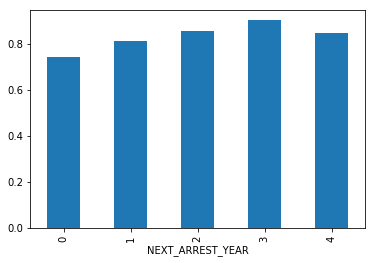

In [650]:
#Recall by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==1], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

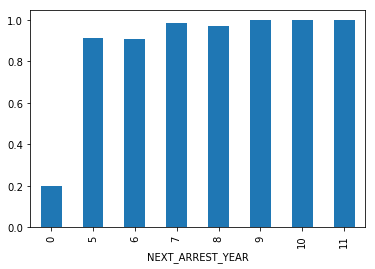

In [71]:
#Percent Predicted Positive Class with a True_Y = 0 by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==0], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

#The model frequently misclassifies people who will be rearrested far in the future as rearrested within 5 years
#however, it rarely (20% of the time) misclassifies people who will never be rearrested

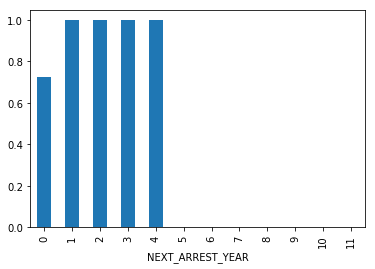

In [72]:
#Precision by next_arrest_year
pd.pivot_table(data[data['Pred_Y'] ==1], values = 'True_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

In [68]:
#Precision by next arrest year
data['COUNT'] = 1
precision_by_arrest_year = pd.pivot_table(data[data['Pred_Y'] ==1], values = ['COUNT', 'CORRECT'], index='NEXT_ARREST_YEAR', aggfunc=sum)

In [69]:
precision_by_arrest_year['Percent'] = precision_by_arrest_year['CORRECT']/precision_by_arrest_year['COUNT']

In [70]:
precision_by_arrest_year

#what does this mean? there are 3,514 records predicted as rearrested with a next_arrest_year of 0
#next_arrest_year of 0 means either not rearrested or rearrested within less than a year

,CORRECT,COUNT,Percent
NEXT_ARREST_YEAR,,,
0,2555,3514,0.727092
1,914,914,1.000000
2,470,470,1.000000
3,298,298,1.000000
4,201,201,1.000000
5,0,162,0.000000
6,0,120,0.000000
7,0,68,0.000000
8,0,37,0.000000


#### The two important boxplots

In [602]:
has_rearrest_incorrect_pred = val_error.wrong_pred[val_error.wrong_pred['True_Y'] == 1]

has_rearrest_correct_pred = val_error.right_pred[val_error.right_pred['True_Y'] == 1]

has_rearrest_incorrect_pred['NEXT_ARREST_TIME'] = has_rearrest_incorrect_pred['NEXT_ARREST_TIME']/365

has_rearrest_incorrect_pred=has_rearrest_incorrect_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

has_rearrest_correct_pred['NEXT_ARREST_TIME'] = has_rearrest_correct_pred['NEXT_ARREST_TIME']/365

has_rearrest_correct_pred=has_rearrest_correct_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

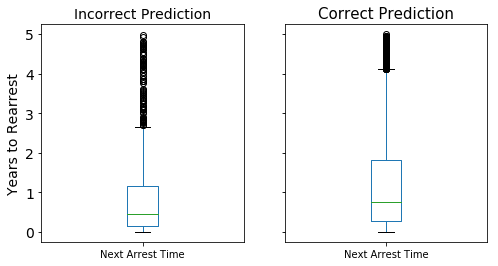

In [620]:
plt.figure(1)
plt.gcf().set_size_inches(8,4) 

rows = 1

ax1 = plt.subplot(rows,2,1)
ax1.set_title('Incorrect Prediction', fontsize=14)
ax1.set_ylabel('Years to Rearrest', fontsize = 14)
ax1.set_yticklabels(labels = [-1,0,1,2,3,4,5], fontdict = {'fontsize': 14})
has_rearrest_incorrect_pred['Next Arrest Time'].plot.box()

ax2 = plt.subplot(rows,2,2, sharey=ax1)
ax2.set_title('Correct Prediction', fontsize=15)
has_rearrest_correct_pred['Next Arrest Time'].plot.box()
plt.savefig('next_arrest_time' + '_boxplots.png')

In [133]:
data[numeric].corrwith(data['NEXT_ARREST_TIME'])

BAR_ADMIT_DAYS            0.025517
NEXT_ARREST_TIME          1.000000
CRIMINAL_FLAG             0.360213
FINAL_DETENTION_FLAG     -0.013526
HABITUAL_OFFENDER_FLAG    0.012818
INITIAL_DETENTION_FLAG   -0.028522
JUVENILE_FLAG            -0.162318
TOT_NUM_DEF              -0.004126
MULTIPLE_DEF_FLAG        -0.003513
SCREENING_DAYS           -0.027164
ARREST_DATE_y            -0.090516
SCREENING_DISP_DATE_y    -0.080199
SCREENING_DISP_DATE_m     0.025482
AGE                       0.056277
ARREST_TO_SCREEN          0.043933
dtype: float64

In [180]:
correlations = data[data['True_Y'] ==1][numeric].corrwith(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

correlations.sort_values()

JUVENILE_FLAG            -0.184845
INITIAL_DETENTION_FLAG   -0.037101
SCREENING_DAYS           -0.021351
MULTIPLE_DEF_FLAG        -0.019601
TOT_NUM_DEF              -0.016906
FINAL_DETENTION_FLAG     -0.015600
SCREENING_DISP_DATE_m     0.004126
HABITUAL_OFFENDER_FLAG    0.006206
ARREST_DATE_y             0.016555
SCREENING_DISP_DATE_y     0.020701
BAR_ADMIT_DAYS            0.025845
ARREST_TO_SCREEN          0.034602
AGE                       0.135949
CRIMINAL_FLAG             0.229738
NEXT_ARREST_TIME          1.000000
dtype: float64

In [ ]:
#pretty highly correlated with criminal flag
#also negatively correlated with juvenile flag
#also slightly correlated with age

In [136]:
from scipy.stats.stats import pearsonr

In [137]:
x = np.array(data[data['True_Y'] ==1]['CRIMINAL_FLAG'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

In [138]:
pearsonr(x,y)

(0.22973757555763877, 3.9304127600190746e-69)

In [148]:
data['Probability'] = best_model_predicted_prob[:,1]

In [149]:
x = np.array(data[data['True_Y'] ==1]['Probability'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

In [150]:
pearsonr(x,y)

(0.14397555115495486, 8.9910517797342953e-28)

In [90]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [113]:
list_to_plot = ['AGE', 'BAR_ADMIT DAYS', 'ARREST_TO_SCREEN', 'SCREENING_DAYS', 'CRIMINAL_FLAG']

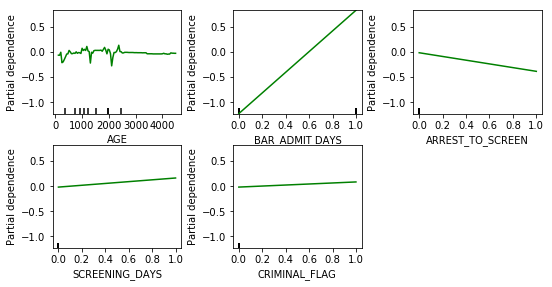

In [135]:
fig, axs = plot_partial_dependence(best_model, X_train, list_to_plot, list_to_plot)

plt.gcf().set_size_inches(8,6)

plt.savefig('partial_dependence.png')

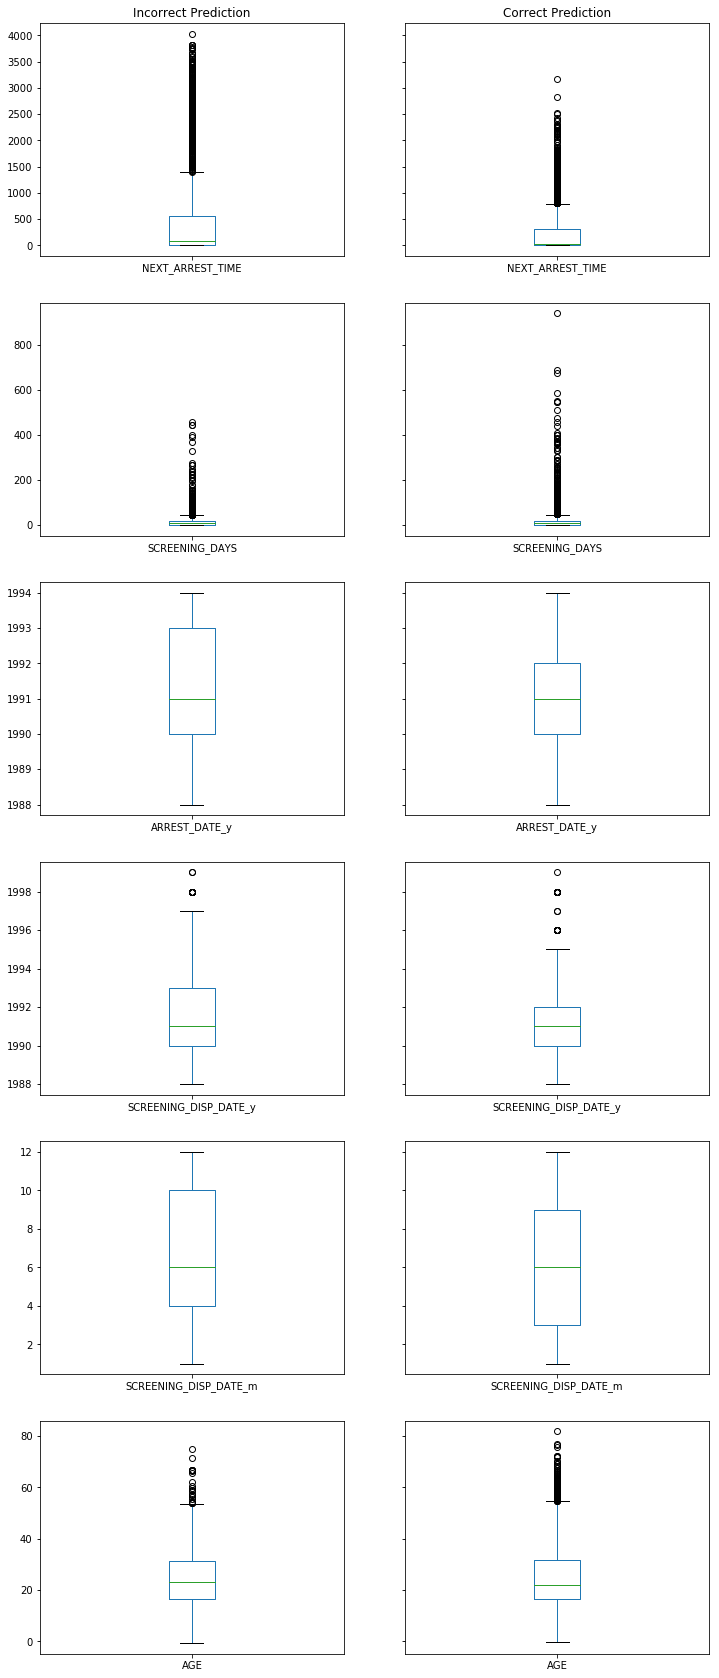

In [509]:
val_error.plot_boxplots(numeric_exc_binary)

In [ ]:
val_error.mean_comparison(numeric)

val_error.correlation(numeric)

In [169]:
val_error.make_cat_breakdowns(categorical_and_binary)

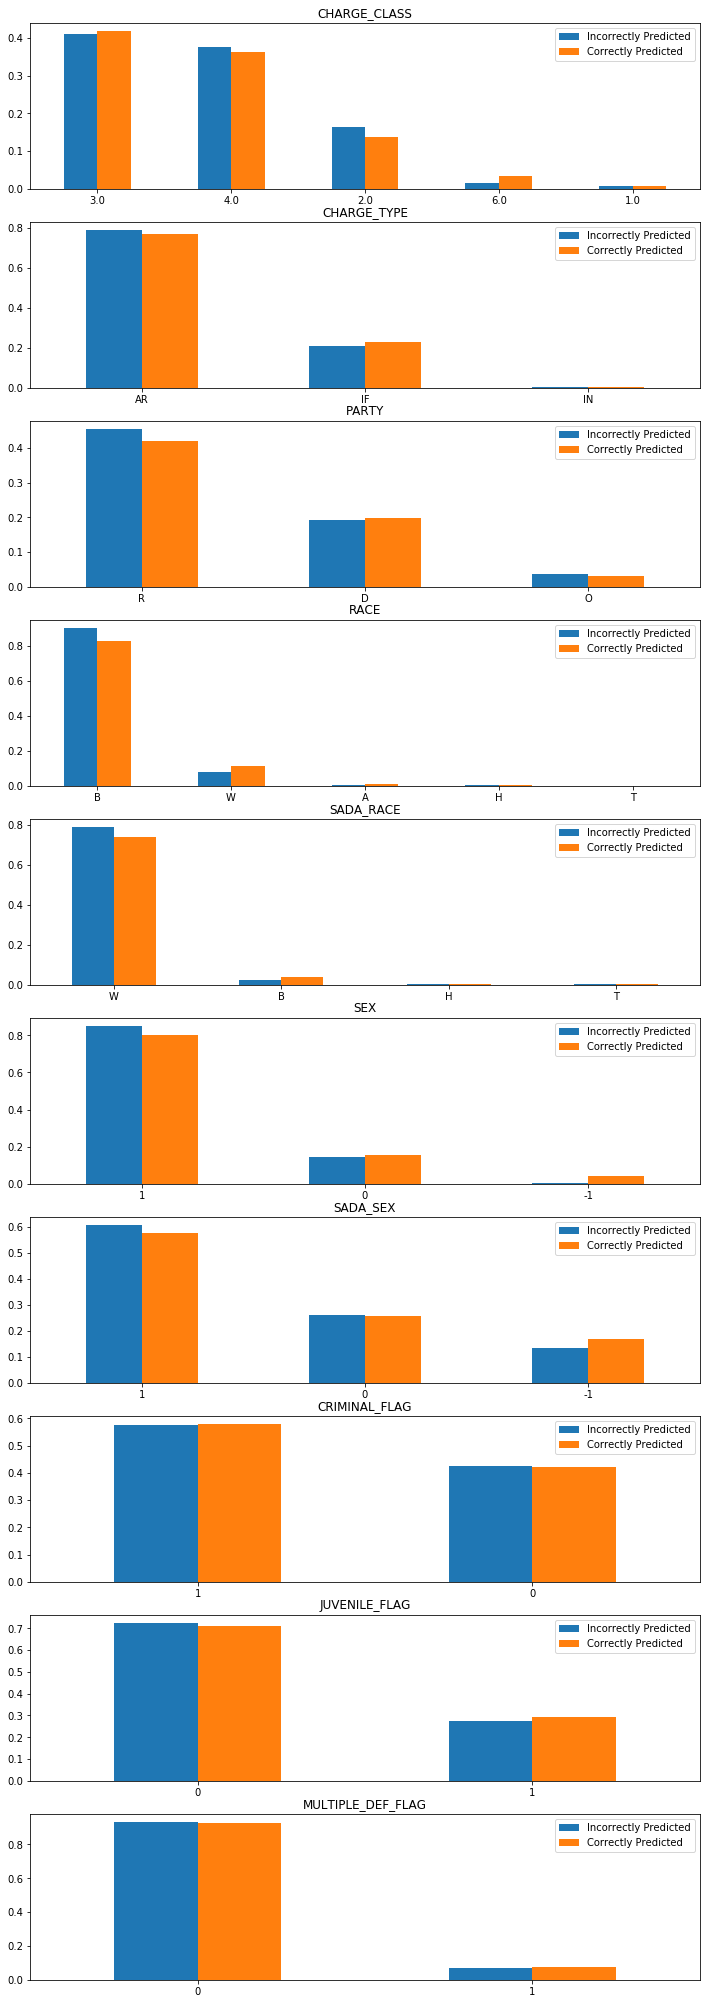

In [178]:
val_error.plot_cat_breakdowns()
plt.gcf().set_size_inches(12,36)
plt.gcf().savefig('final_categorical_breakdowns.png')

# Random Forest

### Default Parameters

In [10]:
rf_clf =  RandomForestClassifier()
rf_clf = rf_clf.fit(X_train,y_train)

rf_pred_train = rf_clf.predict(X_train)
rf_pred_val = rf_clf.predict(X_val)

In [11]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
#a rf ccuracy
rf_accu_train = sklearn.metrics.accuracy_score(y_train,rf_pred_train)
rf_accu_test = sklearn.metrics.accuracy_score(y_val,rf_pred_val)

print("Accuracy on Training Dataset: {}".format(rf_accu_train))
print("Accuracy on Val Dataset: {}".format(rf_accu_test))

Accuracy on Training Dataset: 0.9823520047303905
Accuracy on Val Dataset: 0.7143896670911406


In [13]:
rf_precision = sklearn.metrics.precision_score(y_val,rf_pred_val)
rf_recall = sklearn.metrics.recall_score(y_val,rf_pred_val)
rf_f_score = sklearn.metrics.f1_score(y_val,rf_pred_val)

print("Precision: {}".format(rf_precision))
print("Recall: {}".format(rf_recall))
print("F-Score: {}".format(rf_f_score))

Precision: 0.7409570459683497
Recall: 0.6902421902421902
F-Score: 0.7147010721424677


In [14]:
#confusion matrix for val set
rf_cm = sklearn.metrics.confusion_matrix(y_val,rf_pred_val)
rf_cm    #add cm.to_latex?

array([[3921, 1375],
       [1765, 3933]])

### Parameter Optimization

In [15]:
#Reduced Number of Options for Run-times

n_estimators = [100, 300, 500]
max_features = ['sqrt','log2']
max_depths = [8, 10, 12]
min_samples_splits = [2, 4, 8]

In [16]:
model_specs_rf = pd.DataFrame(list(product(n_estimators, max_features, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'max_features', 'max_depth', 'min_samples_split'])

model_specs_rf['ModelID'] = range(1, len(model_specs_rf)+1)

model_specs_rf['ModelID'] = 'Model' + model_specs_rf['ModelID'].astype(str)

model_specs_rf.head()

,n_estimator,max_features,max_depth,min_samples_split,ModelID
0,100,sqrt,8,2,Model1
1,100,sqrt,8,4,Model2
2,100,sqrt,8,8,Model3
3,100,sqrt,10,2,Model4
4,100,sqrt,10,4,Model5


In [17]:
models_rf = {}

for i in range(len(model_specs_rf)):
    models_rf[model_specs_rf.iloc[i,:]['ModelID']] = \
    RandomForestClassifier(n_estimators = int(model_specs_rf.iloc[i,:]['n_estimator']),\
                               max_features = model_specs_rf.iloc[i,:]['max_features'],\
                               max_depth = model_specs_rf.iloc[i,:]['max_depth'],\
                               min_samples_split = int(model_specs_rf.iloc[i,:]['min_samples_split'])
                              )

In [18]:
models_fit_rf = {k: v.fit(X_train,y_train) for k, v in models_rf.items()}

In [19]:
models_predict_val_rf = {k: v.predict(X_val) for k, v in models_fit_rf.items()}

In [20]:
model_specs_rf.index = model_specs_rf['ModelID']

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val_rf[model_num])

In [25]:
len(model_specs_rf)

54

In [22]:
model_specs_rf.loc[model_specs_rf['F-Score'].idxmax(axis=1),]

n_estimator               500
max_features             sqrt
max_depth                  12
min_samples_split           4
ModelID               Model44
Val Accuracy         0.748681
Precision            0.741246
Recall                0.79133
F-Score               0.76547
Name: Model44, dtype: object

In [23]:
#creates a numeric version of the max_features parameter

model_specs_rf['max_features_number']= \
np.where(model_specs_rf['max_features']=='sqrt', math.sqrt(X_train.shape[1]), math.log(X_train.shape[1],2))

In [134]:
model_specs_rf[0:5]

,n_estimator,max_features,max_depth,min_samples_split,ModelID,Val Accuracy,Precision,Recall,F-Score,max_features_number
ModelID,,,,,,,,,,
Model1,100,sqrt,8,2,Model1,0.737220,0.737688,0.765005,0.751098,9.055385
Model2,100,sqrt,8,4,Model2,0.733491,0.714507,0.809056,0.758848,9.055385
Model3,100,sqrt,8,8,Model3,0.738676,0.738880,0.766760,0.752562,9.055385
Model4,100,sqrt,10,2,Model4,0.744133,0.737762,0.785539,0.760901,9.055385
Model5,100,sqrt,10,4,Model5,0.743133,0.741513,0.774307,0.757555,9.055385


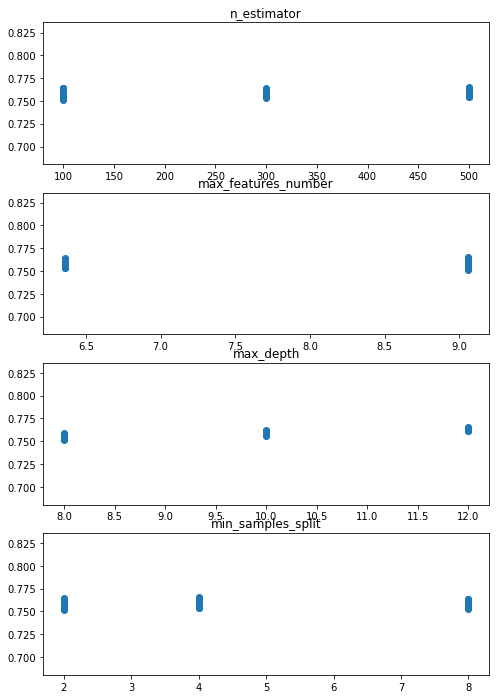

In [183]:
#Plot all the results

params = ['n_estimator', 'max_features_number', 'max_depth', 'min_samples_split']

fig, axes = plt.subplots(nrows=len(params), ncols=1)
y = model_specs_rf['F-Score']

for i in range(len(params)):
    x = model_specs_rf[params[i]]
    ax = axes[i]
    ax.set_title(params[i])
    ax.scatter(x, y)

plt.gcf().set_size_inches(8,12) 
plt.show()